In [ ]:
'''

******Analytical Exercise
 
Banc ABC is a large US Bank that is protected by F5, Inc. They have approached F5 with a special request. They have set up special infrastructure in their environment to service financial aggregators like Mint and 
Plaid who login in to accounts on behalf of Banc ABC’s customers. Traditionally no attention has been paid to these aggregators and they have been allowed unfettered access to Banc ABC’s systems.

A new CISO has taken the reins at Banc ABC and has requested that we look at all the aggregator transactions and provide her with a report. She is specifically concerned about the rate at which aggregators are 
logging into accounts. She is proposing limiting each aggregator to 1 login per account per 10 min interval and would like to know what impact this will have on the aggregators.


Data Provided
You have been provided with two CSV files for the purpose of this exercise.

1.	Aggregator IP List.csv
Contains a list of all the allowlisted (whitelisted) IPs that belong to known financial aggregators that are allowed by Banc ABC to access their customer’s accounts. The format of the file is
IP: contains the IP addresses belonging to the aggregators that have been allowlisted
Aggregator: contains the name of the aggregator that owns the respective allowlisted IP address

2.	Login Transactions.csv
This file contains all the logins observed by F5 over a 24 hour period on Banc ABC’s special Aggregator ONLY endpoint. This endpoint was set up specifically to process transactions for the allowlisted aggregators so as not 
to interfere with regular customer traffic which uses a different endpoint.

The format of the file is:
IP: This is the IP address from which the login transaction came
LoginSuccess: This is an indicator of whether or not the login was successful i.e. had the correct accountName and password pair
AccountName: this is the account that the transaction was trying to log into
Timestamp: this is the epoch timestamp at which the respective login transaction was received
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Required

1.	Which aggregators are accessing Banc ABC’s systems?
2.	How much volume are the aggregators sending?
3.	How many individual user accounts are being accessed by the aggregators?
4.	What is the login success rate of these aggregators and is this in line with what would be expected in your opinion?
5.	What is the average number of transactions each aggregator sends per 10min interval?
6.	What is the maximum number of transactions each aggregator sends per 10min interval?
7.	What would be the impact of the CISO’s proposal to limit each aggregator to 1 login per account per 10 min interval?

Guidance
●	Feel free to use any analytical tools you feel comfortable with to perform the analysis and prepare the presentation for the CISO. We recommend, but do not require, use of Jupyter notebooks.
●	Be prepared to show your code or worksheets and to answer questions about your thought and analytical processes.
●	Presentation will be over Zoom to the Banc ABC CISO and will be scheduled for 1 hour, including questions.

You have 3 days to prepare the deck and email it to the Banc ABC CISO (please email directly to the Threat Analytics & Reporting team distro: tar@f5.com)


'''

In [125]:
#as 1st step lets add common libraries
import pandas as pd
import numpy as np
import matplotlib as plt
print('lets start preprocessing data')
# we can get the data using pandas as files we have csv files
aggregator_ip_list = pd.read_csv(r'C:\Users\ARMANDO\Documents\Python Scripts\Challenges\F5\Aggregator IP List.csv', index_col=0)
login_transactions = pd.read_csv(r'C:\Users\ARMANDO\Documents\Python Scripts\Challenges\F5\Login Transactions.csv', index_col=0)

print(login_transactions.dtypes)
print('----------------------------------')
print(aggregator_ip_list.dtypes)

# Always is good to see the overal info from data. this alows us to undestand what we have and what we need to do...

print(aggregator_ip_list.describe().round(2))
print('-------------------------------------------------')
print(login_transactions.describe().round(2))
print('complete')
#we can see IP \neq ip, so lets change to IP instead of ip

print('***********************next process*************************')
aggregator_ip_list.rename(columns={'ip': 'IP'}, inplace=True)
# aggregator_ip_list.head()

# lets convert timestamp columns into datetime object for easier manipulation
login_transactions['timestamp'] = pd.to_datetime(login_transactions['timestamp'], unit='ms')
print('LoginSuccess is not numeric, converting to boolean (0, 1)')
login_transactions['LoginSuccess'] = login_transactions['LoginSuccess'].map({'Fail': 0, 'Success': 1})

print('format complete!')
print('generating master table...')

# As we to relate info from two tables it is covenient to merge/join the tables to add "aggregator names" to the "login transactions" table

merged_data = login_transactions.merge(aggregator_ip_list, on='IP', how='left') # understand correctly this join
merged_data.dropna(subset=['Aggregator'])
print(merged_data.head(1))
print(merged_data.describe().round(2))
print('------------------------------------------------------------------------')
print(merged_data.head(5))

# 1. Which aggregators are accessing Banc ABCs systems?
#to solve it we only need to get the uniques aggregators from table
aggregators_accessing = merged_data['Aggregator'].unique()
print(aggregators_accessing)
print('------------------------------------------------------')
# 2. How much volume are the aggregators sending?
#this is a simple count
aggregator_volume = merged_data['Aggregator'].value_counts()
print(aggregator_volume)
# 3. How many individual user accounts are being accessed by the aggregators?
#this is a count by aggregator
individual_accounts = merged_data.groupby('Aggregator')['AccountName'].nunique()
print(individual_accounts)
print('-------------------------------------------------------------------------')

#4. What is the login success rate of these aggregators and is this in line with what would be expected in your opinion?
print(merged_data['LoginSuccess'].unique())
print('success rate:...')
success_rate_per_aggregator = merged_data.groupby('Aggregator')['LoginSuccess'].mean().round(2)
print("Login success rate per aggregator:\n", success_rate_per_aggregator)
merged_data['Timestamp']=merged_data['timestamp']
print(merged_data)
# 5.- What is the average number of transactions each aggregator sends per 10min interval?
merged_data.set_index('timestamp', inplace=True) # ste set index es problematico
average_transactions_per_10min = merged_data.groupby('Aggregator').resample('10T').size().groupby('Aggregator').mean()
print("Average number of transactions per 10-minute interval per aggregator:\n", round(average_transactions_per_10min, 2))


# merged_data['timestamp'] = merged_data['timestamp'].floor('10T')
# average_transactions_per_10min = merged_data.groupby(['Aggregator', 'TimeInterval']).size().groupby('Aggregator').mean()

# 6. What is the maximum number of transactions each aggregator sends per 10min interval?
max_transactions_per_10min = merged_data.groupby('Aggregator').resample('10T').size().groupby('Aggregator').max()
print("Maximum number of transactions per 10-minute interval per aggregator:\n", max_transactions_per_10min)

# 7.	What would be the impact of the CISO’s proposal to limit each aggregator to 1 login per account per 10 min interval?

def limit_logins(df):
    df = df.sort_values(by='Timestamp')
    df['Allowed'] = df.groupby(['AccountName', 'Aggregator'])['Timestamp'].diff().gt(pd.Timedelta(minutes=10))
    df['Allowed'] = df['Allowed'].fillna(True)  # The first login should be allowed
    return df

limited_logins = merged_data.groupby('Aggregator').apply(limit_logins).reset_index(drop=True)
allowed_logins_count = limited_logins[limited_logins['Allowed']].groupby('Aggregator').size()
print("Allowed logins count per aggregator under the new policy:\n", allowed_logins_count)

impact = (aggregator_volume - allowed_logins_count) / aggregator_volume * 100
print("Impact of the new policy (reduction in allowed logins) per aggregator (%):\n", impact)

lets start preprocessing data
IP              object
LoginSuccess    object
AccountName     object
timestamp        int64
dtype: object
----------------------------------
ip            object
Aggregator    object
dtype: object
                  ip Aggregator
count            315        315
unique           315          7
top     54.208.59.10  YoungOnes
freq               1        249
-------------------------------------------------
          timestamp
count  4.092253e+06
mean   1.540746e+12
std    2.496030e+07
min    1.540703e+12
25%    1.540724e+12
50%    1.540748e+12
75%    1.540768e+12
max    1.540789e+12
complete
***********************next process*************************
LoginSuccess is not numeric, converting to boolean (0, 1)
format complete!
generating master table...
             IP  LoginSuccess      AccountName               timestamp  \
0  54.208.59.10             0  756bb790d96873a 2018-10-28 05:00:00.016   

  Aggregator  
0        AWS  
       LoginSuccess             

C:\Users\ARMANDO\AppData\Local\Temp\ipykernel_13456\3773102585.py:66: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  average_transactions_per_10min = merged_data.groupby('Aggregator').resample('10T').size().groupby('Aggregator').mean()


Average number of transactions per 10-minute interval per aggregator:
 Aggregator
AWS          15154.68
FinTech       2149.68
FunTown          0.53
Insight       1485.65
PayTM          626.94
YoungOnes     6378.83
dtype: float64


C:\Users\ARMANDO\AppData\Local\Temp\ipykernel_13456\3773102585.py:74: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  max_transactions_per_10min = merged_data.groupby('Aggregator').resample('10T').size().groupby('Aggregator').max()


Maximum number of transactions per 10-minute interval per aggregator:
 Aggregator
AWS          16238
FinTech       6903
FunTown          3
Insight       5960
PayTM          744
YoungOnes     9535
dtype: int64


C:\Users\ARMANDO\AppData\Local\Temp\ipykernel_13456\3773102585.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  limited_logins = merged_data.groupby('Aggregator').apply(limit_logins).reset_index(drop=True)


Allowed logins count per aggregator under the new policy:
 Aggregator
AWS          161937
FinTech       96701
FunTown           2
Insight       17726
PayTM          2026
YoungOnes    157985
dtype: int64
Impact of the new policy (reduction in allowed logins) per aggregator (%):
 Aggregator
AWS          92.579438
FinTech      68.761185
FunTown      75.000000
Insight      91.714267
PayTM        97.755871
YoungOnes    82.800647
dtype: float64


            Aggregator Volume  Individual Accounts  Login Success Rate  \
Aggregator                                                               
AWS                   2182274              1923202                0.00   
FinTech                309554               204821                0.00   
FunTown                     8                    5                0.38   
Insight                213934               181749                0.95   
PayTM                   90280                83403                0.15   
YoungOnes              918552               479764                0.70   

            Average Transactions per 10min  Max Transactions per 10min  \
Aggregator                                                               
AWS                           15154.680556                       16238   
FinTech                        2149.680556                        6903   
FunTown                           0.533333                           3   
Insight                        1485.6

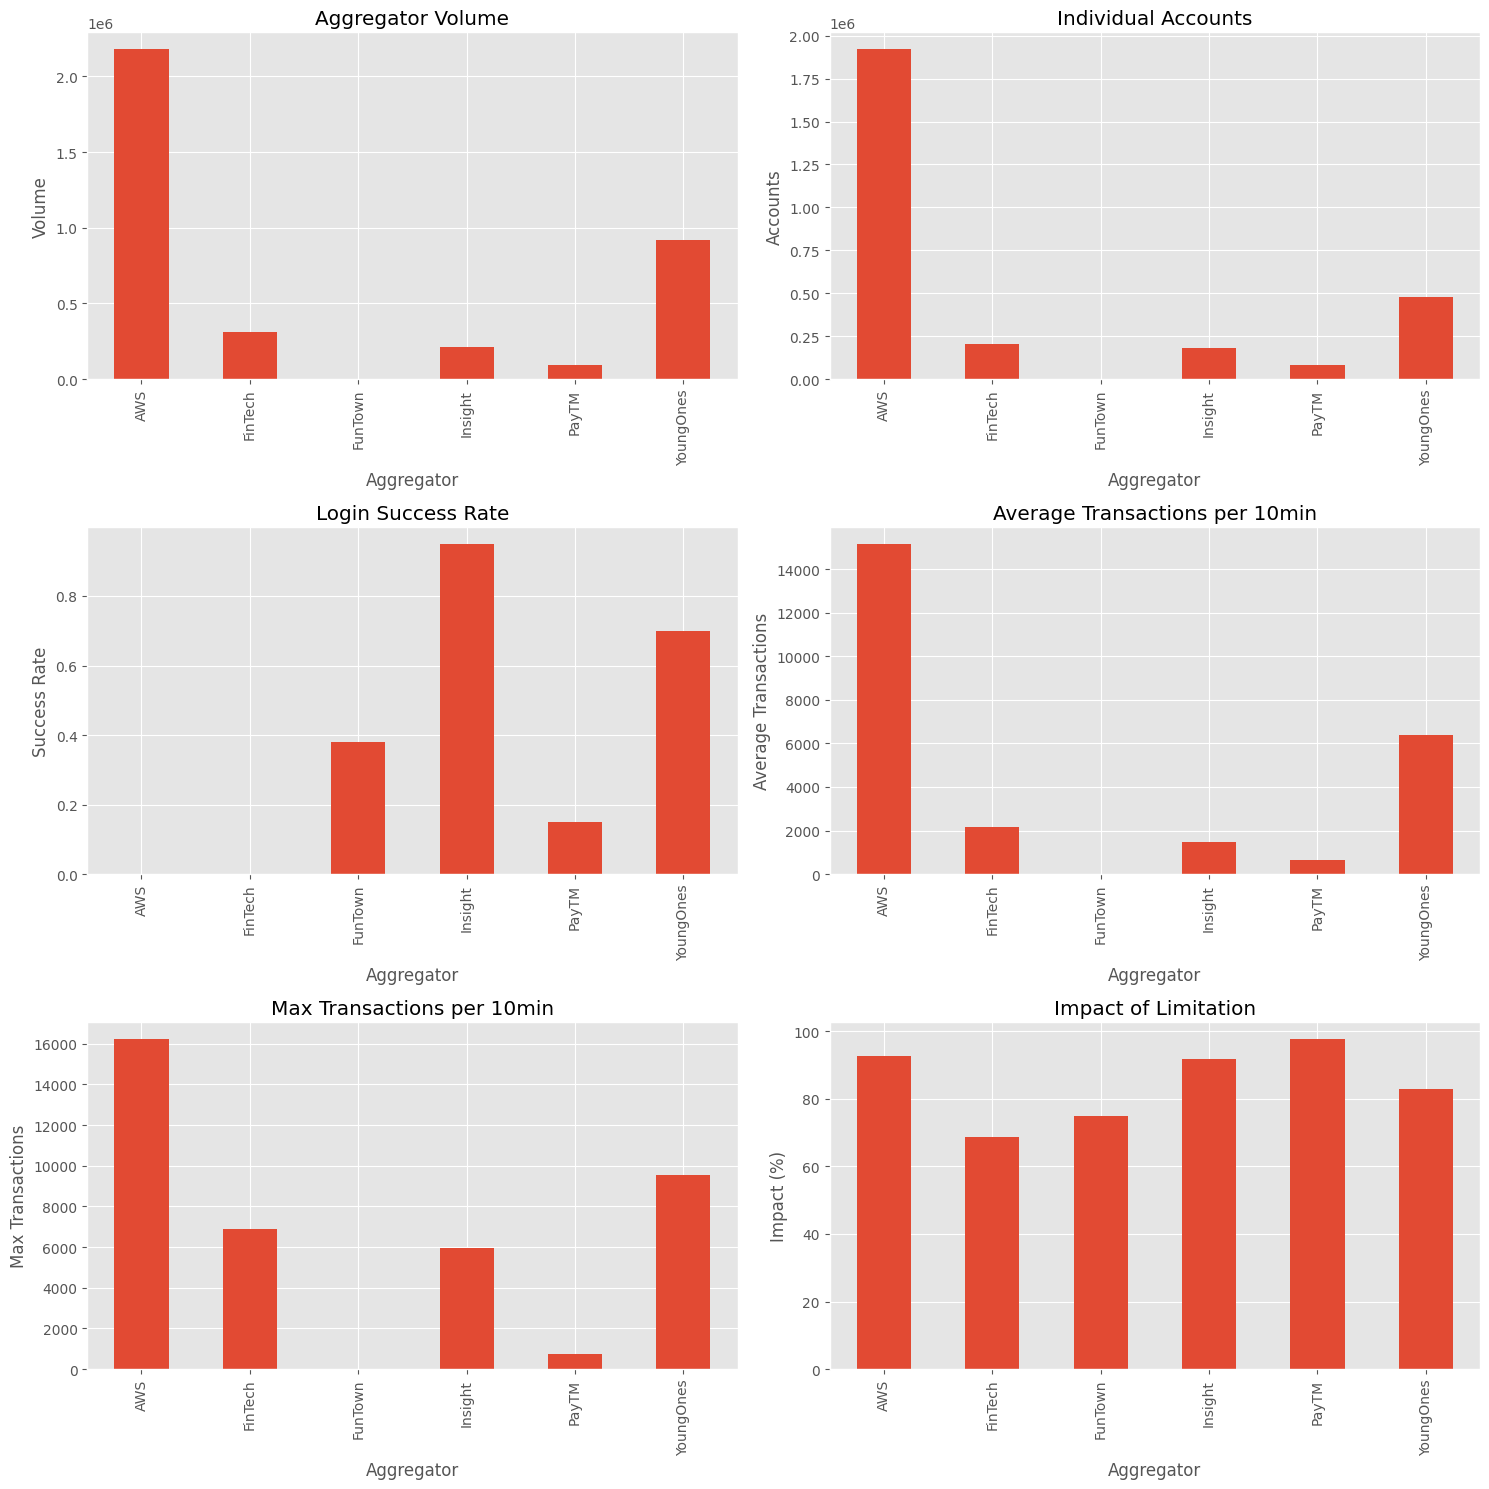

,Aggregator Volume,Individual Accounts,Login Success Rate,Average Transactions per 10min,Max Transactions per 10min,Impact of Limitation
Aggregator,,,,,,
AWS,2182274,1923202,0.00,15154.680556,16238,92.579438
FinTech,309554,204821,0.00,2149.680556,6903,68.761185
FunTown,8,5,0.38,0.533333,3,75.000000
Insight,213934,181749,0.95,1485.652778,5960,91.714267
PayTM,90280,83403,0.15,626.944444,744,97.755871
YoungOnes,918552,479764,0.70,6378.833333,9535,82.800647


In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Configurar el estilo de matplotlib
plt.style.use('ggplot')  # Estilo similar a seaborn-darkgrid, pero más estándar

# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'Aggregator Volume': aggregator_volume,
    'Individual Accounts': individual_accounts,
    'Login Success Rate': success_rate_per_aggregator,
    'Average Transactions per 10min': average_transactions_per_10min,
    'Max Transactions per 10min': max_transactions_per_10min,
    'Impact of Limitation': impact
})


# aggregator_volume
# individual_accounts
# success_rate_per_aggregator
# average_transactions_per_10min
# max_transactions_per_10min
# impact

# Llenar con NaN en caso de que no haya datos para alguna métrica
results_df = results_df.fillna(0)

# Mostrar la tabla
print(results_df)

# Si quieres guardar la tabla en un archivo CSV
results_df.to_csv('results.csv', index=True)

# Crear subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Volumen de agregadores
results_df['Aggregator Volume'].plot(kind='bar', ax=axes[0, 0], title='Aggregator Volume')
axes[0, 0].set_ylabel('Volume')

# Cuentas individuales accedidas
results_df['Individual Accounts'].plot(kind='bar', ax=axes[0, 1], title='Individual Accounts')
axes[0, 1].set_ylabel('Accounts')

# Tasa de éxito de inicio de sesión
results_df['Login Success Rate'].plot(kind='bar', ax=axes[1, 0], title='Login Success Rate')
axes[1, 0].set_ylabel('Success Rate')

# Promedio de transacciones por 10 minutos
results_df['Average Transactions per 10min'].plot(kind='bar', ax=axes[1, 1], title='Average Transactions per 10min')
axes[1, 1].set_ylabel('Average Transactions')

# Máximo de transacciones por 10 minutos
results_df['Max Transactions per 10min'].plot(kind='bar', ax=axes[2, 0], title='Max Transactions per 10min')
axes[2, 0].set_ylabel('Max Transactions')

# Impacto de la limitación
results_df['Impact of Limitation'].plot(kind='bar', ax=axes[2, 1], title='Impact of Limitation')
axes[2, 1].set_ylabel('Impact (%)')


# Ajustar el layout
plt.tight_layout()

# Mostrar las gráficas
plt.show()

results_df